In [1]:
from __future__ import division
import sys
import configparser
import json
import h5py as h5
import gzip
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../Utils')
from utils import get_image_filename, invert_dict, get_a_by_b, query_by_id
from utils import plot_labelled_bb, plot_img_cropped, plot_img_ax
from data_utils import get_obj_bb, get_obj_key
sys.path.append('../WACs/WAC_Utils')
from wac_utils import filter_X_by_filelist, filter_refdf_by_filelist
from wac_utils import create_word2den, make_X_id_index, make_mask_matrix
from wac_utils import train_this_word, get_X_for_word

config = configparser.ConfigParser()
my_config = '../Config/default.cfg'
with open(my_config, 'r', encoding='utf-8') as f:
    config.read_file(f)

dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')
preproc_path = dsgv_home + '/Preproc/PreprocOut/'
feats_path = dsgv_home + '/ExtractFeats/ExtractOut/'
model_path = dsgv_home + '/WACs/ModelsOut/'

In [2]:
# Dataset split
with open(preproc_path + 'fr_splits.json', 'r') as f:
    splits = json.load(f)

# Image features
with h5.File(feats_path + 'saiapr_bbdf_rsn50-max.hdf5') as f:
    X = np.array(f["img_feats"])
X_tr = filter_X_by_filelist(X, splits['train'])
print('X_tr shape:', X_tr.shape)

# Bounding boxes
s_bbdf = pd.read_json(preproc_path + 'saiapr_bbdf.json.gz',
                      typ='frame', orient='split', compression='gzip')

X_tr shape: (2569, 2058)


In [3]:
# EN ref exps
refexp_en = pd.read_json(preproc_path + 'saiapr_refdf.json.gz',
                          typ='frame', orient='split', compression='gzip')
re_en = filter_refdf_by_filelist(refexp_en, splits['train'])
len(refexp_en)
#re_en.head()

120081

In [4]:
# FR ref exps
refexp_fr = pd.read_pickle(preproc_path + 'FR_small_dataset.pkl')
print('refexp_fr shape:', refexp_fr.shape)
# Train set
re_fr = filter_refdf_by_filelist(refexp_fr, splits['train'])
print('Training dataset:')
re_fr.head()

refexp_fr shape: (10159, 7)
Training dataset:


,i_corpus,image_id,region_id,r_corpus,rex_id,refexp_EN,refexp
0,0,14576,1,referit,2,seal,phoque
1,0,14576,2,referit,96551,bottom left corner,coin inférieur gauche
2,0,25137,2,referit,71,bottom right con\rner,coin en bas à droite
3,0,25137,1,referit,83240,plane,avion
4,0,26897,1,referit,86,door,porte


In [14]:
# EN classifier
with gzip.open(model_path + 'wac_EN_3.pklz', 'r') as rf:
    en_wacs = pickle.load(rf)

en_wacs['seal']

{'npos': 133,
 'n': 20133,
 'clsf': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf', LogisticRegression(max_iter=500, warm_start=True))])}

/Users/beckalina/PycharmProjects/WAC/clp-vision-master/Data/IAPR_ReferIt/SAIA_Data/benchmark/saiapr_tc-12/14/images/14576.jpg


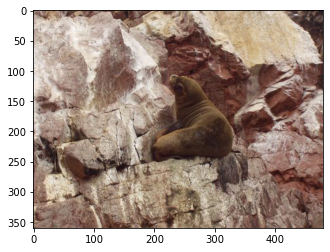

In [71]:
ic = 0  # saiapr corpus code
ii = re_fr['image_id'][0]

seal = get_image_filename(config, ic, ii)

print(seal)
plt.imshow(plt.imread(seal))

In [72]:
seal_feats = filter_X_by_filelist(X_tr, [14576,])
seal_feats  # note first 3 values are corpus code, image id, & region id

array([[0.00000000e+00, 1.45760000e+04, 1.00000000e+00, ...,
        1.05462963e-01, 1.33333333e+00, 8.56997342e-02],
       [0.00000000e+00, 1.45760000e+04, 2.00000000e+00, ...,
        9.95144676e-01, 1.33333333e+00, 2.35702260e-03],
       [0.00000000e+00, 1.45760000e+04, 3.00000000e+00, ...,
        3.53836806e-01, 1.33333333e+00, 4.41669811e-01]])

In [22]:
def apply_words(X_tst, wac, refexp_toks_wac):
    response_vectors = []
    for word in refexp_toks_wac:
        response_vector = np.array(wac[word]['clsf'].predict_proba(X=X_tst)[:,1])
        # removed confidences bit for now for readability
        response_vectors.append(response_vector)
    response_matrix = np.array(response_vectors).T   # n_objs x n_words
    return response_matrix

In [47]:
POSTIDINDEX = 3
compfunc=lambda x:np.sum(x, axis=1)

refexps = [['seal'], ['brown', 'seal'], ['blue', 'house'], ['man'], ['rock']]
results = []
for re in refexps:
    reg_probs = apply_words(seal_feats[:, POSTIDINDEX:], en_wacs, re)
    results.append(reg_probs)
results

[array([[9.99630526e-01],
        [5.52522125e-02],
        [6.81659211e-05]]),
 array([[3.98678386e-07, 9.99630526e-01],
        [8.47170258e-07, 5.52522125e-02],
        [2.05962475e-05, 6.81659211e-05]]),
 array([[1.72795359e-03, 9.39148455e-14],
        [3.04905918e-06, 5.93260386e-12],
        [5.54268463e-03, 4.45415096e-07]]),
 array([[3.63775742e-01],
        [2.18679736e-04],
        [1.76157671e-04]]),
 array([[0.99999698],
        [0.99999987],
        [0.98260618]])]

In [48]:
composed = []
for r in results:
    cr = compfunc(r)
    print(cr)
    composed.append(cr)

[9.99630526e-01 5.52522125e-02 6.81659211e-05]
[9.99630925e-01 5.52530597e-02 8.87621686e-05]
[1.72795359e-03 3.04906511e-06 5.54313004e-03]
[3.63775742e-01 2.18679736e-04 1.76157671e-04]
[0.99999698 0.99999987 0.98260618]


In [49]:
idx = ['seal', 'brown seal', 'blue house', 'man', 'rock']
df = pd.DataFrame.from_records(composed, index=idx, columns=['reg1', 'reg2', 'reg3'])
df

,reg1,reg2,reg3
seal,0.999631,0.055252,0.000068
brown seal,0.999631,0.055253,0.000089
blue house,0.001728,0.000003,0.005543
man,0.363776,0.000219,0.000176
rock,0.999997,1.000000,0.982606


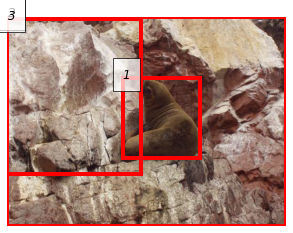

In [46]:
bbs = [(bb, region_id) 
       for bb, region_id in query_by_id(s_bbdf, (ic, ii), ['bb', 'region_id']).values]
plot_labelled_bb(seal, bbs, figsize=(5,5))

In [79]:
seal_reg_fts = seal_feats[:, POSTIDINDEX:]
prob = np.array(en_wacs['seal']['clsf'].predict_proba(X=seal_reg_fts)[:,1])
prob

array([9.99630526e-01, 5.52522125e-02, 6.81659211e-05])

In [56]:
pred = np.array(en_wacs['seal']['clsf'].predict(X=seal_feats[:, POSTIDINDEX:]))
pred

array([1, 0, 0])

In [106]:
# Get probabilities for each word on region
seal_reg_fts = seal_feats[:, POSTIDINDEX:]
reg_probs = np.zeros((len(en_wacs), len(seal_reg_fts)))

for i,w in enumerate(en_wacs.keys()):
    prob = np.array(en_wacs[w]['clsf'].predict_proba(X=seal_reg_fts)[:,1])
    reg_probs[i] = prob

probs_df = pd.DataFrame(reg_probs, index=en_wacs.keys(), columns=['reg1', 'reg2', 'reg3'])
probs_df

,reg1,reg2,reg3
at,7.128733e-02,1.596075e-02,7.678286e-03
very,2.661791e-06,3.009717e-03,6.327480e-04
top,2.236283e-01,1.540918e-01,8.341215e-01
guy,6.616968e-03,7.242748e-06,9.017121e-05
in,8.133090e-01,6.664876e-02,4.915594e-01
...,...,...,...
cake,2.000515e-07,7.373749e-08,3.648143e-07
this,1.318287e-04,1.449658e-06,4.670320e-06
fish,4.493869e-05,3.876632e-06,5.562778e-05
church,1.096982e-11,1.080418e-09,5.363273e-10


In [107]:
probs_df.idxmax()

reg1     rock
reg2     rock
reg3    rocks
dtype: object

In [108]:
probs_df.reg1.sort_values(ascending=False).head(n=10)

rock      0.999997
seal      0.999631
most      0.997515
mid       0.953452
in        0.813309
right     0.630318
person    0.626528
that      0.594751
of        0.523080
center    0.496762
Name: reg1, dtype: float64

In [109]:
probs_df.reg2.sort_values(ascending=False).head(n=10)

rock        1.000000
anywhere    0.999999
red         0.999992
rocks       0.999969
upper       0.994775
wall        0.972912
but         0.885472
corner      0.658787
anything    0.497087
picture     0.481671
Name: reg2, dtype: float64

In [110]:
probs_df.reg3.sort_values(ascending=False).head(n=10)

rocks    0.999587
big      0.998312
upper    0.986494
rock     0.982606
left     0.915028
pic      0.899771
top      0.834122
or       0.607458
in       0.491559
wall     0.407863
Name: reg3, dtype: float64

In [114]:
# Keep only high probabilities?
high_probs = np.zeros_like(reg_probs)

it = np.nditer(reg_probs, flags=['multi_index'])
for p in it:
    if p > 0.75:
        idx = it.multi_index
        high_probs[idx[0]][idx[1]] = p
high_probs

array([[0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.83412152],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [122]:
# Could also use only EN WACs with good accuracy/F1 scores?
word2den = create_word2den(re_en)
X_idx = make_X_id_index(X_tr)
mask_matrix = make_mask_matrix(X_tr, X_idx, word2den, word2den.keys())


scores = []
for i,w in enumerate(en_wacs.keys()):
    if w in word2den:
        X, y = get_X_for_word(X_tr, word2den, mask_matrix, w)
        score = en_wacs[w]['clsf'].score(X, y)
        scores.append(score)
        print(w,'\t\t', score)
    else:
        scores.append(0.0)

at 		 0.9571817827948618
very 		 0.9462826002335539
top 		 0.8781627092253795
guy 		 0.917866874270144
in 		 0.8310626702997275
the 		 0.6940443752432853
middle 		 0.9089139743090697
front 		 0.9279875437913585
upper 		 0.9377189567925263
right 		 0.8540288049824835
corner 		 0.9225379525107046
any 		 0.9462826002335539
of 		 0.8341767224601012
people 		 0.9361619307123394
on 		 0.7306344881276762
left 		 0.8657065005838848
sky 		 0.9564032697547684
rocks 		 0.9735305566368236
bottom 		 0.8602569093032308
hat 		 0.9754768392370572
dude 		 0.9715842740365901
trees 		 0.9400544959128065
tower 		 0.9961074347995329
sand 		 0.9606850914752822
girl 		 0.9439470611132736
is 		 0.9447255741533671
laying 		 0.9996107434799533
face 		 0.9789801479174777
dirt 		 0.9746983261969638
path 		 0.9964966913195796
man 		 0.927209030751265
head 		 0.9785908913974309
a 		 0.9673024523160763
tree 		 0.929933826391592
umbrella 		 0.9988322304398599
plate 		 0.9953289217594394
closest 		 0.9388867263526665


purple 		 0.9961074347995329
portion 		 0.9976644608797197
has 		 0.9992214869599065
bush 		 0.9871545348384585
mtn 		 0.9976644608797197
1 		 0.9980537173997664
seal 		 0.9976644608797197
walls 		 0.9992214869599065
nightstand 		 0.9988322304398599
cap 		 0.9988322304398599
anyone 		 0.9980537173997664
kids 		 0.9976644608797197
women 		 0.9996107434799533
us 		 0.9789801479174777
rocky 		 0.9992214869599065
bus 		 0.997275204359673
vehicle 		 0.9996107434799533
coat 		 0.9968859478396264
plane 		 0.9988322304398599
entire 		 0.9988322304398599
beneath 		 0.997275204359673
fountain 		 0.9968859478396264
biggest 		 0.9996107434799533
whole 		 0.9984429739198132
drink 		 0.9992214869599065
court 		 0.9992214869599065
dead 		 0.9992214869599065
square 		 0.9992214869599065
train 		 0.9996107434799533
no 		 0.9922148695990658
child 		 0.997275204359673
fruit 		 0.9961074347995329
out 		 0.9968859478396264
gate 		 0.9988322304398599
old 		 0.9992214869599065
beige 		 0.9996107434799533
bld

In [121]:
scores_df = pd.Series(scores, index=en_wacs.keys())
scores_df.sort_values(ascending=False)

penguin    1.000000
ice        1.000000
women      0.999611
okay       0.999611
llama      0.999611
             ...   
houses     0.000000
gravel     0.000000
blonde     0.000000
see        0.000000
pack       0.000000
Length: 406, dtype: float64

In [126]:
# Append to feature vector
print(seal_reg_fts.shape)
print(high_probs.shape)
print(high_probs.T.shape)

(3, 2055)
(406, 3)
(3, 406)


In [133]:
phoque_fts = np.concatenate((seal_reg_fts, high_probs.T), axis=1, dtype='<f8')
phoque_fts.shape

(3, 2461)